Let's create a Python notebook to train a ViT model for image classification. 
TomatoPlantfactoryDataset is the root of your dataSets being trained in this notebook.
We'll assume that your "Images" folder contains the tomato plant images, and the "labels" folder contains corresponding classification labels. Here's a step-by-step guide:

First, let's set up the notebook with necessary imports and check if GPU is available:


In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import AdamW
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader, random_split
 
from transformers import ViTForImageClassification
 
from tqdm import tqdm



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.4.1+cu118
CUDA version: 11.8
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 2060


In [3]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import AdamW
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader, random_split
 
from transformers import ViTForImageClassification
 
from tqdm import tqdm



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


Using device: cuda


Next, we'll create a custom dataset class:

In [14]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from collections import Counter
from typing import List, Tuple, Callable, Dict
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

class TomatoPlantDataset(Dataset):
    def __init__(self, image_dir: str, label_dir: str, annotation_dir: str, transform: Callable = None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.images = self._get_image_files(image_dir)

    @staticmethod
    def _get_image_files(directory: str) -> List[str]:
        return [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, List[Dict[str, float]], str]:
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + '.txt')
        annotation_path = os.path.join(self.annotation_dir, os.path.splitext(img_name)[0] + '.xml')

        self._check_file_exists(img_path)
        self._check_file_exists(label_path)
        self._check_file_exists(annotation_path)

        image = self._load_image(img_path)
        label = self._get_label(label_path)
        annotation = self._get_annotation(annotation_path)

        if self.transform:
            image = self.transform(image)

        return image, annotation, img_name

    @staticmethod
    def _check_file_exists(file_path: str) -> None:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

    @staticmethod
    def _load_image(img_path: str) -> Image.Image:
        return Image.open(img_path).convert('RGB')

    @staticmethod
    def _get_label(label_path: str) -> int:
        with open(label_path, 'r') as f:
            label_content = f.read().strip().split('\n')
        labels = [int(line.split()[0]) for line in label_content]
        return Counter(labels).most_common(1)[0][0]

    @staticmethod
    def _get_annotation(annotation_path: str) -> List[Dict[str, float]]:
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        bboxes = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
            
            # Convert to center coordinates and normalized dimensions
            x_center = (xmin + xmax) / (2 * width)
            y_center = (ymin + ymax) / (2 * height)
            box_width = (xmax - xmin) / width
            box_height = (ymax - ymin) / height
            
            bboxes.append({
                'class_id': name,  # Use the name as class_id for now
                'x_center': x_center,
                'y_center': y_center,
                'width': box_width,
                'height': box_height
            })
        return bboxes

def create_transform() -> Callable:
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

def create_dataset_and_dataloader(image_dir: str, label_dir: str, annotation_dir: str, batch_size: int = 32, shuffle: bool = True) -> Tuple[Dataset, DataLoader]:
    transform = create_transform()
    dataset = TomatoPlantDataset(image_dir, label_dir, annotation_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataset, dataloader

def display_image_with_bboxes(image: Image.Image, bboxes: List[Dict[str, float]], title: str):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    
    for bbox in bboxes:
        x_center, y_center = bbox['x_center'], bbox['y_center']
        width, height = bbox['width'], bbox['height']
        
        x = (x_center - width/2) * image.width
        y = (y_center - height/2) * image.height
        w = width * image.width
        h = height * image.height
        
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f"{bbox['class_id']}", color='r', fontsize=12, fontweight='bold')
    
    plt.title(title)
    plt.axis('off')
    plt.show()

def inspect_dataset(dataset: TomatoPlantDataset, num_samples: int = 5):
    for _ in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, annotation, img_name = dataset[idx]
        
        # Convert the tensor back to PIL Image for display
        image_pil = transforms.ToPILImage()(image)
        
        print(f"\nImage: {img_name}")
        print("Annotation content:")
        for bbox in annotation:
            print(f"Class {bbox['class_id']}: center=({bbox['x_center']:.2f}, {bbox['y_center']:.2f}), "
                  f"size=({bbox['width']:.2f}, {bbox['height']:.2f})")
        
        display_image_with_bboxes(image_pil, annotation, f"Image: {img_name}")

# Usage
image_dir = './TomatoPlantfactoryDataset/Images'
label_dir = './TomatoPlantfactoryDataset/labels'
annotation_dir = './TomatoPlantfactoryDataset/annotations'

dataset, dataloader = create_dataset_and_dataloader(image_dir, label_dir, annotation_dir)
print(f"Dataset size: {len(dataset)}")
print(f"Number of batches in dataloader: {len(dataloader)}")


Dataset size: 520
Number of batches in dataloader: 17


## Image Processing

Images are processed using the following transformations:
1. Resized to 224x224 pixels
2. Converted to PyTorch tensors
3. Normalized using ImageNet mean and standard deviation

## Label Processing

1. Each image has a corresponding text file in the `labels` directory.
2. Label files are read and processed to extract the most common label.
3. Labels are converted to integers (0 or 1).

## Data Loading Process

1. The `TomatoPlantDataset` class handles data loading:
   - Reads image files from the `Images` directory
   - Matches each image with its label file
   - Loads and processes images on-the-fly
   - Extracts labels from corresponding text files

2. The `DataLoader` batches the data:
   - Default batch size: 32
   - Shuffling enabled for training

## Important Considerations

1. **Label Meaning**: The specific meaning of labels 0 and 1 is not provided in the current implementation. This information should be clarified before training.

2. **Class Imbalance**: The slight imbalance between classes may need to be addressed during model training, possibly through class weighting or data augmentation.

3. **Data Verification**: It's crucial to visually inspect some images and their corresponding labels to ensure correct label assignment and understand the classification task.

4. **Performance Optimization**: Depending on dataset size and available computational resources, consider using techniques like caching or pre-loading to improve data loading speed during training.

## Next Steps

1. Determine the exact meaning of labels 0 and 1 (e.g., healthy vs. diseased, ripe vs. unripe).
2. Visually inspect a sample of images from each class to confirm label accuracy.
3. Consider implementing data augmentation techniques to address class imbalance and improve model generalization.
4. Proceed with model selection, training, and evaluation using this preprocessed dataset.



Image: 0078.JPG
Label content:
Class 0: center=(0.42, 0.39), size=(0.16, 0.25)
Class 0: center=(0.63, 0.36), size=(0.16, 0.25)
Class 0: center=(0.59, 0.54), size=(0.15, 0.20)
Class 0: center=(0.68, 0.64), size=(0.13, 0.18)
Class 0: center=(0.51, 0.49), size=(0.09, 0.16)

Annotation content:
Class green: center=(0.42, 0.39), size=(0.16, 0.25)
Class green: center=(0.63, 0.36), size=(0.16, 0.25)
Class green: center=(0.59, 0.54), size=(0.15, 0.20)
Class green: center=(0.68, 0.64), size=(0.13, 0.18)
Class green: center=(0.51, 0.49), size=(0.09, 0.16)


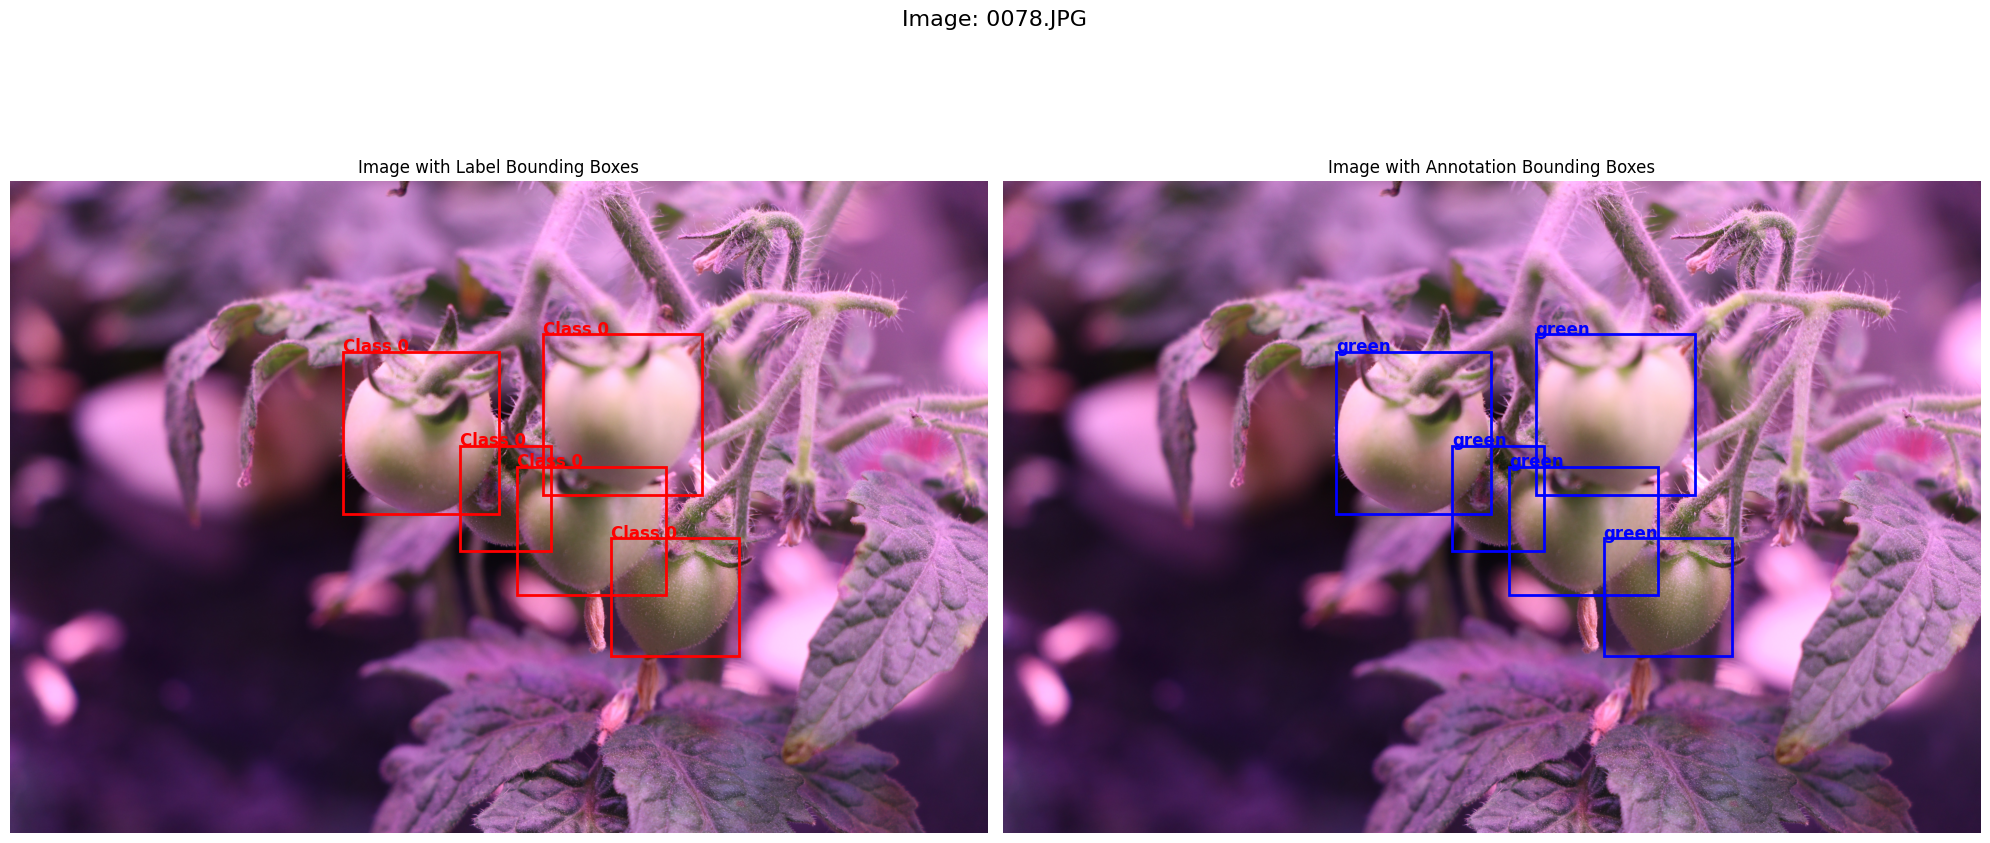


Image: 0003.JPG
Label content:
Class 0: center=(0.29, 0.34), size=(0.07, 0.07)
Class 0: center=(0.83, 0.59), size=(0.11, 0.12)
Class 0: center=(0.78, 0.37), size=(0.11, 0.11)
Class 0: center=(0.32, 0.21), size=(0.11, 0.12)
Class 0: center=(0.34, 0.66), size=(0.13, 0.20)
Class 0: center=(0.78, 0.52), size=(0.17, 0.22)
Class 0: center=(0.67, 0.32), size=(0.14, 0.18)
Class 0: center=(0.41, 0.61), size=(0.15, 0.24)
Class 0: center=(0.19, 0.34), size=(0.15, 0.15)
Class 0: center=(0.46, 0.82), size=(0.15, 0.21)
Class 0: center=(0.64, 0.54), size=(0.18, 0.27)
Class 0: center=(0.81, 0.15), size=(0.17, 0.23)

Annotation content:
Class green: center=(0.29, 0.34), size=(0.07, 0.07)
Class green: center=(0.83, 0.59), size=(0.11, 0.12)
Class green: center=(0.78, 0.37), size=(0.11, 0.11)
Class green: center=(0.32, 0.21), size=(0.11, 0.12)
Class green: center=(0.34, 0.66), size=(0.13, 0.20)
Class green: center=(0.78, 0.52), size=(0.17, 0.22)
Class green: center=(0.67, 0.32), size=(0.14, 0.18)
Class g

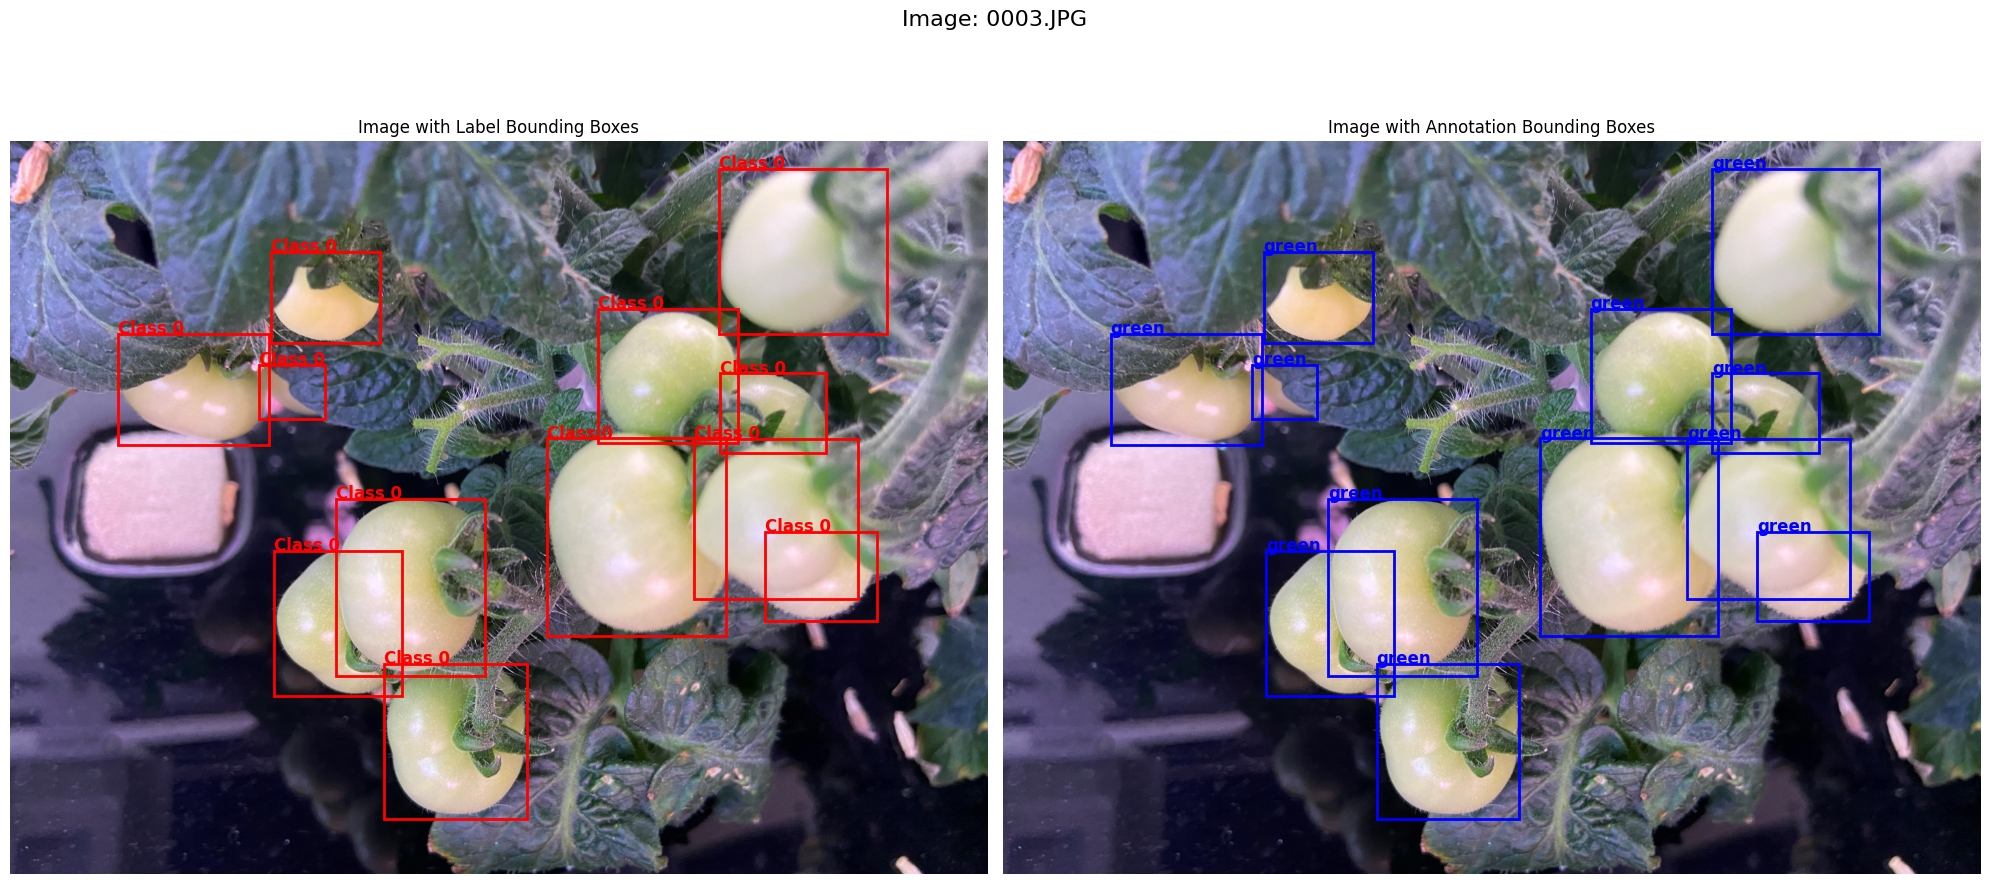


Image: 0283.JPG
Label content:
Class 0: center=(0.59, 0.40), size=(0.12, 0.18)
Class 0: center=(0.36, 0.52), size=(0.12, 0.17)
Class 0: center=(0.92, 0.06), size=(0.07, 0.08)
Class 0: center=(0.30, 0.44), size=(0.09, 0.11)
Class 0: center=(0.30, 0.68), size=(0.08, 0.10)

Annotation content:
Class green: center=(0.59, 0.40), size=(0.12, 0.18)
Class green: center=(0.36, 0.52), size=(0.12, 0.17)
Class green: center=(0.92, 0.06), size=(0.07, 0.08)
Class green: center=(0.30, 0.44), size=(0.09, 0.11)
Class green: center=(0.30, 0.68), size=(0.08, 0.10)


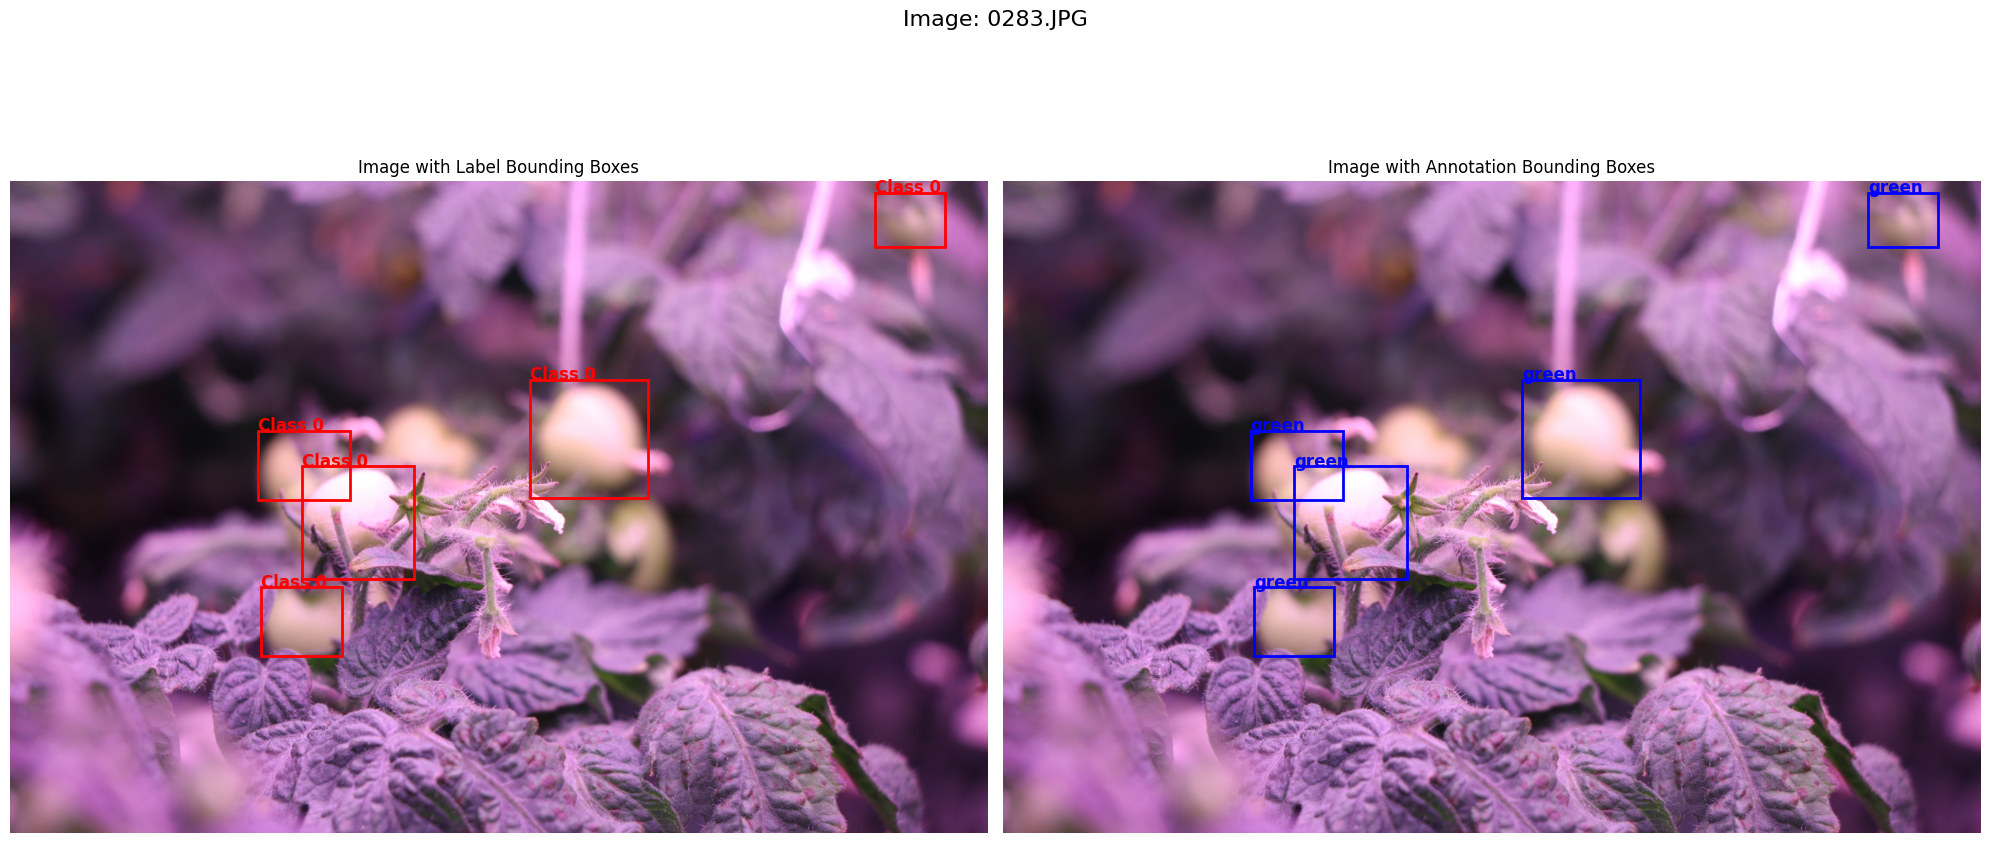


Image: 0260.JPG
Label content:
Class 0: center=(0.85, 0.91), size=(0.09, 0.11)
Class 0: center=(0.75, 0.92), size=(0.09, 0.12)
Class 0: center=(0.73, 0.83), size=(0.06, 0.08)
Class 0: center=(0.45, 0.66), size=(0.07, 0.10)
Class 0: center=(0.40, 0.50), size=(0.06, 0.08)
Class 0: center=(0.45, 0.37), size=(0.04, 0.06)
Class 0: center=(0.28, 0.49), size=(0.07, 0.10)
Class 0: center=(0.29, 0.08), size=(0.04, 0.06)
Class 0: center=(0.12, 0.36), size=(0.06, 0.09)
Class 0: center=(0.19, 0.40), size=(0.07, 0.11)

Annotation content:
Class green: center=(0.86, 0.16), size=(0.07, 0.10)
Class green: center=(0.73, 0.19), size=(0.08, 0.10)
Class green: center=(0.85, 0.91), size=(0.09, 0.11)
Class green: center=(0.75, 0.92), size=(0.09, 0.12)
Class green: center=(0.73, 0.83), size=(0.06, 0.08)
Class green: center=(0.45, 0.66), size=(0.07, 0.10)
Class green: center=(0.47, 0.58), size=(0.05, 0.06)
Class green: center=(0.51, 0.56), size=(0.06, 0.10)
Class green: center=(0.40, 0.50), size=(0.06, 0.08)

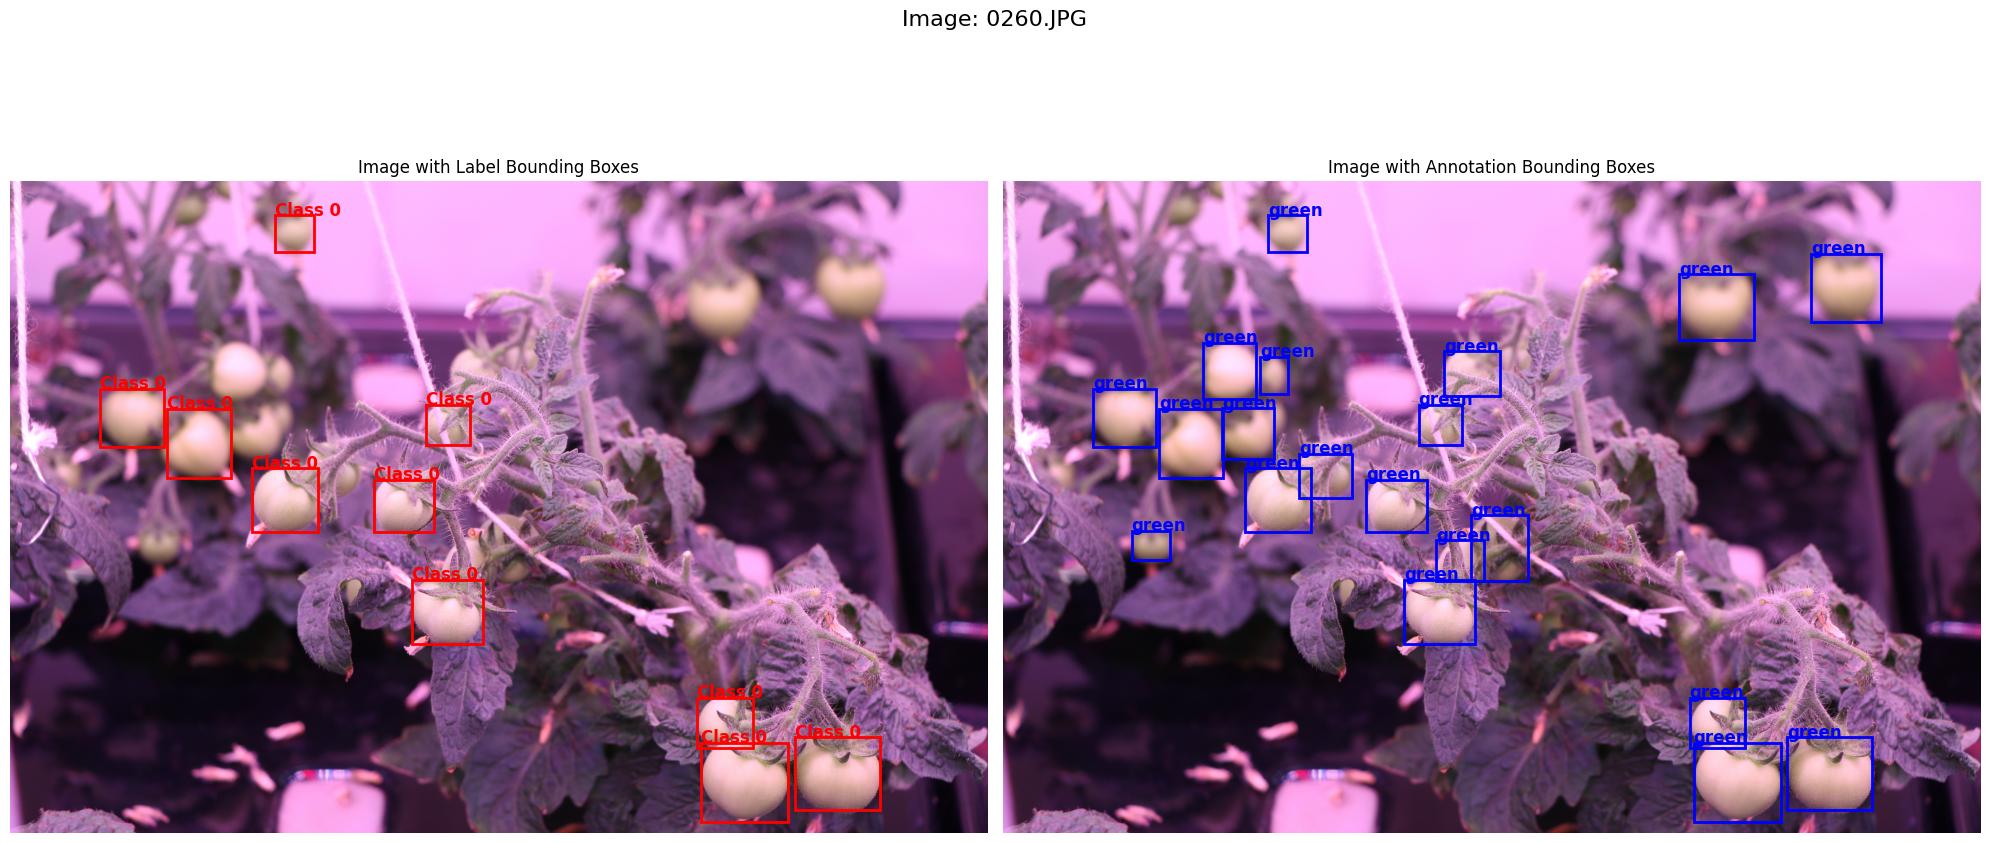


Image: 0310.JPG
Label content:
Class 0: center=(0.88, 0.57), size=(0.24, 0.40)
Class 1: center=(0.74, 0.02), size=(0.10, 0.04)
Class 0: center=(0.92, 0.31), size=(0.15, 0.27)
Class 0: center=(0.83, 0.28), size=(0.07, 0.10)
Class 1: center=(0.05, 0.38), size=(0.06, 0.08)
Class 0: center=(0.62, 0.18), size=(0.06, 0.07)
Class 0: center=(0.31, 0.54), size=(0.08, 0.10)
Class 0: center=(0.33, 0.40), size=(0.09, 0.17)
Class 0: center=(0.11, 0.47), size=(0.08, 0.10)
Class 0: center=(0.51, 0.70), size=(0.14, 0.20)
Class 1: center=(0.20, 0.52), size=(0.13, 0.13)
Class 1: center=(0.43, 0.51), size=(0.11, 0.14)
Class 1: center=(0.75, 0.12), size=(0.12, 0.15)
Class 1: center=(0.58, 0.12), size=(0.10, 0.12)
Class 0: center=(0.10, 0.34), size=(0.14, 0.16)
Class 0: center=(0.23, 0.43), size=(0.15, 0.16)
Class 1: center=(0.41, 0.66), size=(0.13, 0.18)
Class 0: center=(0.68, 0.86), size=(0.22, 0.28)
Class 0: center=(0.24, 0.25), size=(0.16, 0.18)
Class 0: center=(0.76, 0.50), size=(0.12, 0.25)
Class 1:

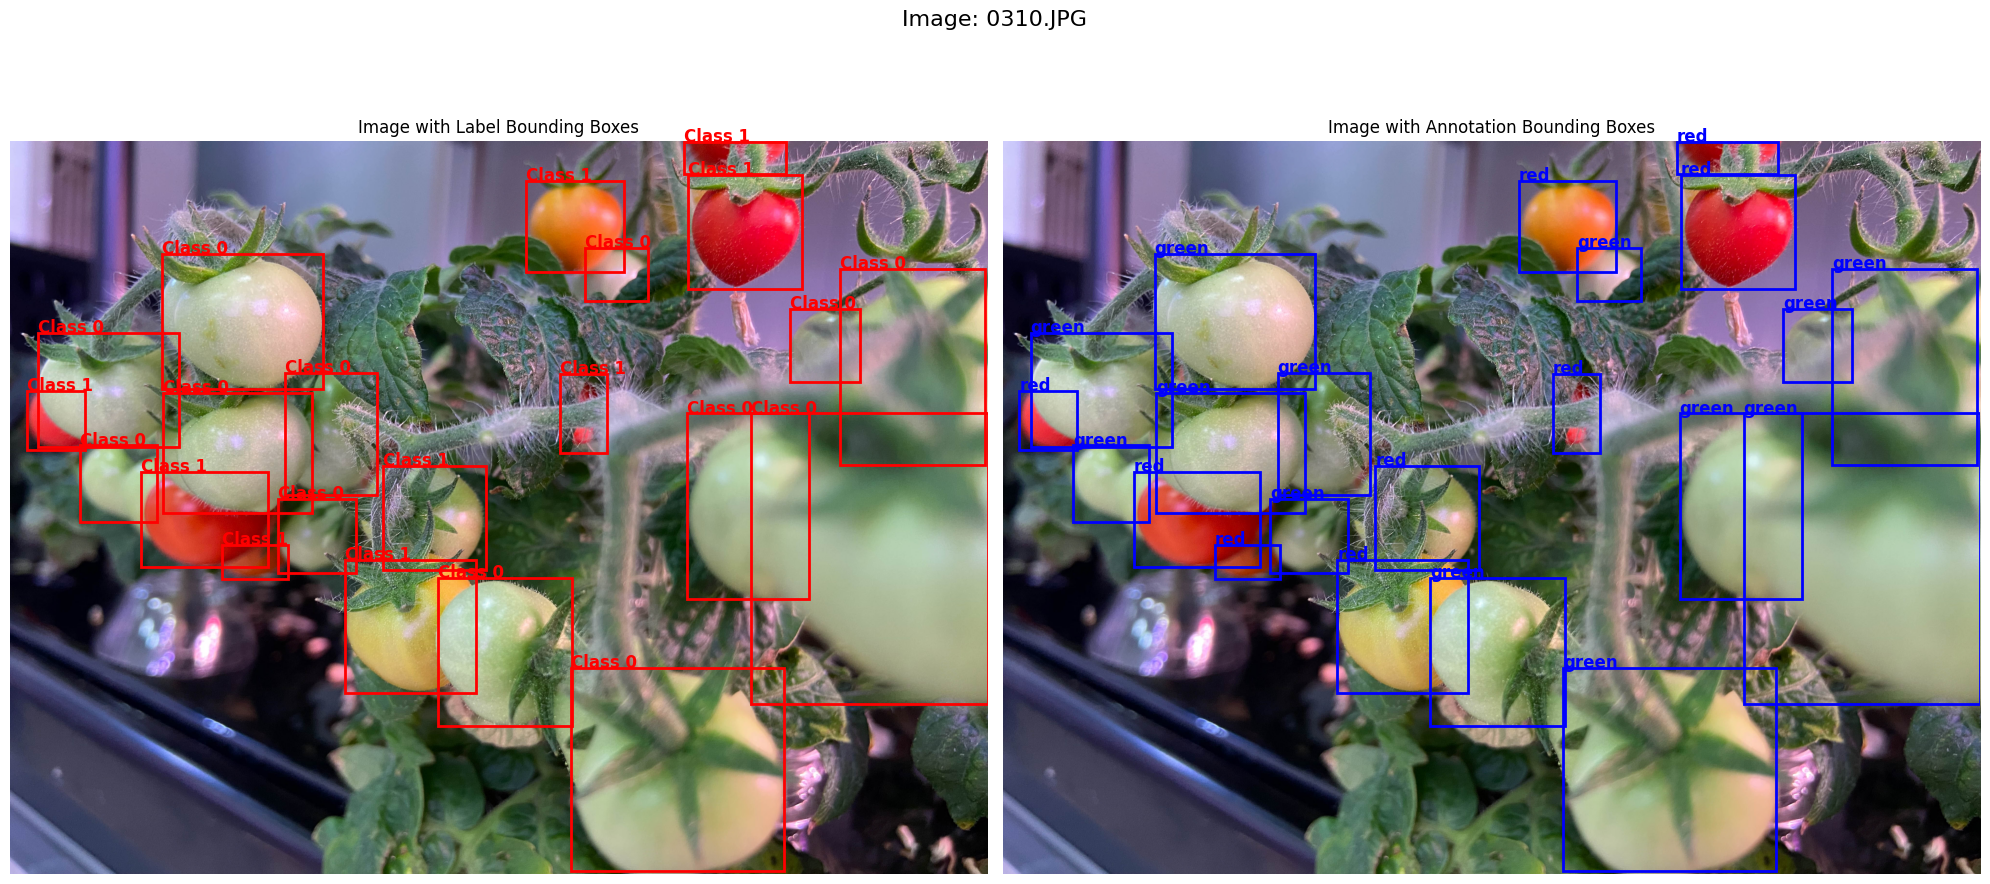

In [15]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from typing import List, Dict
import xml.etree.ElementTree as ET

def read_label_file(label_path: str) -> List[Dict[str, float]]:
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    bboxes = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            class_id, x_center, y_center, width, height = map(float, parts)
            bboxes.append({
                'class_id': int(class_id),
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })
    return bboxes

def read_annotation_file(annotation_path: str) -> List[Dict[str, float]]:
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    
    bboxes = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)
        
        # Convert to center coordinates and normalized dimensions
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        box_width = (xmax - xmin) / width
        box_height = (ymax - ymin) / height
        
        bboxes.append({
            'class_id': name,
            'x_center': x_center,
            'y_center': y_center,
            'width': box_width,
            'height': box_height
        })
    return bboxes

def display_image_with_bboxes(image_path: str, label_path: str, annotation_path: str):
    img = Image.open(image_path)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Display image with label bboxes
    ax1.imshow(img)
    bboxes_label = read_label_file(label_path)
    for bbox in bboxes_label:
        x_center, y_center = bbox['x_center'], bbox['y_center']
        width, height = bbox['width'], bbox['height']
        
        x = (x_center - width/2) * img.width
        y = (y_center - height/2) * img.height
        w = width * img.width
        h = height * img.height
        
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
        ax1.text(x, y, f"Class {bbox['class_id']}", color='r', fontsize=12, fontweight='bold')
    
    ax1.set_title("Image with Label Bounding Boxes")
    ax1.axis('off')
    
    # Display image with annotation bboxes
    ax2.imshow(img)
    bboxes_annotation = read_annotation_file(annotation_path)
    for bbox in bboxes_annotation:
        x_center, y_center = bbox['x_center'], bbox['y_center']
        width, height = bbox['width'], bbox['height']
        
        x = (x_center - width/2) * img.width
        y = (y_center - height/2) * img.height
        w = width * img.width
        h = height * img.height
        
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='b', facecolor='none')
        ax2.add_patch(rect)
        ax2.text(x, y, f"{bbox['class_id']}", color='b', fontsize=12, fontweight='bold')
    
    ax2.set_title("Image with Annotation Bounding Boxes")
    ax2.axis('off')
    
    plt.suptitle(f"Image: {os.path.basename(image_path)}", fontsize=16)
    plt.tight_layout()
    plt.show()

def inspect_dataset(image_dir: str, label_dir: str, annotation_dir: str, num_samples: int = 5):
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for _ in range(num_samples):
        img_name = random.choice(image_files)
        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')
        annotation_path = os.path.join(annotation_dir, os.path.splitext(img_name)[0] + '.xml')
        
        print(f"\nImage: {img_name}")
        print("Label content:")
        bboxes_label = read_label_file(label_path)
        for bbox in bboxes_label:
            print(f"Class {bbox['class_id']}: center=({bbox['x_center']:.2f}, {bbox['y_center']:.2f}), "
                  f"size=({bbox['width']:.2f}, {bbox['height']:.2f})")
        
        print("\nAnnotation content:")
        bboxes_annotation = read_annotation_file(annotation_path)
        for bbox in bboxes_annotation:
            print(f"Class {bbox['class_id']}: center=({bbox['x_center']:.2f}, {bbox['y_center']:.2f}), "
                  f"size=({bbox['width']:.2f}, {bbox['height']:.2f})")
        
        display_image_with_bboxes(img_path, label_path, annotation_path)

# Usage
image_dir = './TomatoPlantfactoryDataset/Images'
label_dir = './TomatoPlantfactoryDataset/labels'
annotation_dir = './TomatoPlantfactoryDataset/annotations'

inspect_dataset(image_dir, label_dir, annotation_dir, num_samples=5)



# TomatoPlantfactoryDataset Inspection Tool

This Jupyter notebook cell provides a comprehensive tool for inspecting and visualizing the TomatoPlantfactoryDataset, which contains images of tomato fruits for object detection in plant factory environments.

## Features

1. **Label Parsing**: Reads and decodes the label information from text files.
2. **Image Visualization**: Displays images with bounding boxes drawn around detected objects.
3. **Dataset Inspection**: Randomly samples images from the dataset for review.

## Code Structure

### 1. `read_label_file(label_path: str) -> List[Dict[str, float]]`
- Parses the label file and extracts bounding box information.
- Returns a list of dictionaries containing class ID and normalized coordinates.

### 2. `display_image_with_bboxes(image_path: str, label_path: str)`
- Opens and displays an image using matplotlib.
- Draws bounding boxes on the image based on label information.
- Annotates each box with its class ID.

### 3. `inspect_dataset(image_dir: str, label_dir: str, num_samples: int = 5)`
- Randomly selects images from the dataset.
- Prints label information for each selected image.
- Visualizes each image with its corresponding bounding boxes.

## Usage

1. Set the `image_dir` and `label_dir` variables to point to your dataset directories.
2. Run the `inspect_dataset` function, specifying the number of samples to review.

## Benefits

- Quickly verify the correctness of labels in your dataset.
- Visualize object detection annotations to ensure accuracy.
- Gain insights into the distribution and variety of images in your dataset.

This tool is invaluable for dataset quality assurance and understanding the characteristics of the TomatoPlantfactoryDataset.


Dataset size: 520
Number of batches in dataloader: 17
Tensor shape: torch.Size([3, 224, 224])
Tensor min: -1.9131652116775513
Tensor max: 2.640000104904175


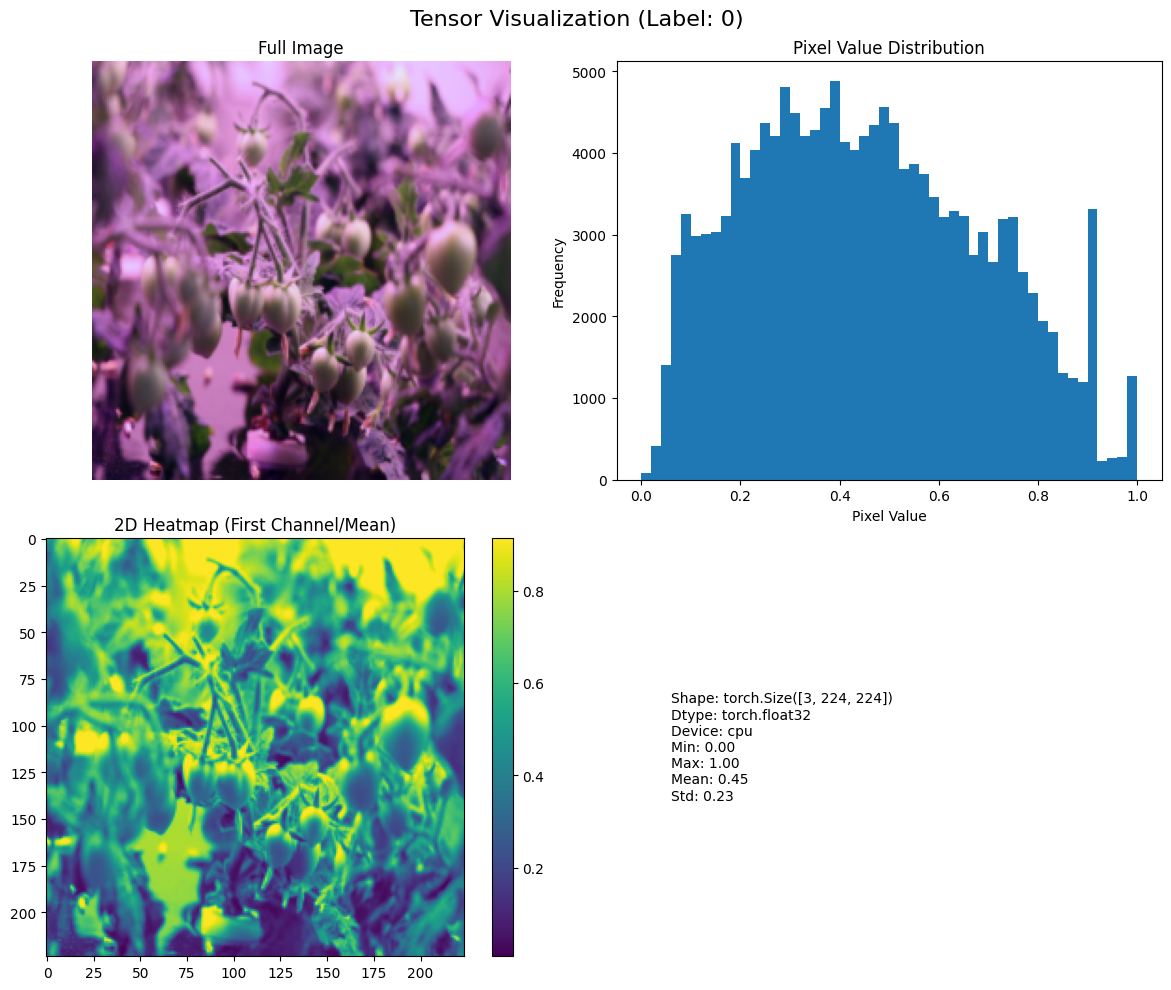

First batch shape: torch.Size([32, 3, 224, 224])
First batch labels: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1])


In [5]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

def normalize_for_display(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

def visualize_tensor_details(tensor, label):
    # Ensure the tensor is on CPU and detached from the computation graph
    tensor = tensor.cpu().detach()

    # Normalize tensor for display
    tensor = normalize_for_display(tensor)

    # Get tensor shape and other details
    shape = tensor.shape
    dtype = tensor.dtype
    device = tensor.device
    min_val = tensor.min().item()
    max_val = tensor.max().item()
    mean_val = tensor.mean().item()
    std_val = tensor.std().item()

    # Determine the number of channels
    if len(shape) == 3:
        num_channels = shape[0]
    else:
        num_channels = 1

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Tensor Visualization (Label: {label})", fontsize=16)

    # Plot the full image
    if num_channels == 3:
        img_to_show = tensor.permute(1, 2, 0)
    elif num_channels == 1:
        img_to_show = tensor.squeeze()
    else:
        img_to_show = tensor.mean(dim=0)  # Average across channels if more than 3

    axes[0, 0].imshow(img_to_show, cmap='gray' if num_channels == 1 else None)
    axes[0, 0].set_title("Full Image")
    axes[0, 0].axis('off')

    # Plot histogram of pixel values
    axes[0, 1].hist(tensor.flatten().numpy(), bins=50)
    axes[0, 1].set_title("Pixel Value Distribution")
    axes[0, 1].set_xlabel("Pixel Value")
    axes[0, 1].set_ylabel("Frequency")

    # Plot tensor as a 2D heatmap (first channel or mean)
    heatmap_data = tensor[0] if num_channels > 0 else tensor.mean(dim=0)
    im = axes[1, 0].imshow(heatmap_data, cmap='viridis')
    axes[1, 0].set_title("2D Heatmap (First Channel/Mean)")
    fig.colorbar(im, ax=axes[1, 0])

    # Display tensor details as text
    details_text = (
        f"Shape: {shape}\n"
        f"Dtype: {dtype}\n"
        f"Device: {device}\n"
        f"Min: {min_val:.2f}\n"
        f"Max: {max_val:.2f}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Std: {std_val:.2f}"
    )
    axes[1, 1].text(0.1, 0.5, details_text, fontsize=10, va='center')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
image_dir = './TomatoPlantfactoryDataset/Images'
label_dir = './TomatoPlantfactoryDataset/labels'
dataset, dataloader = create_dataset_and_dataloader(image_dir, label_dir)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches in dataloader: {len(dataloader)}")

# Visualize tensor details for the first image
first_image, first_label = dataset[0]
print("Tensor shape:", first_image.shape)
print("Tensor min:", first_image.min().item())
print("Tensor max:", first_image.max().item())
visualize_tensor_details(first_image, first_label)

# Print the first batch to understand the data structure
for batch_images, batch_labels in dataloader:
    print("First batch shape:", batch_images.shape)
    print("First batch labels:", batch_labels)
    break



# Understanding Tensor Visualization in PyTorch

In the realm of machine learning with PyTorch, understanding and visualizing tensor data is crucial. Tensors, which are multi-dimensional arrays similar to NumPy arrays but with additional features for GPU acceleration and automatic differentiation, form the foundation of data representation in PyTorch.

## Process Overview

1. **Data Loading**: Creation of a dataset and dataloader from image files and their corresponding labels.

2. **Tensor Inspection**: Extraction of the first image and label from the dataset.

3. **Tensor Visualization**: Implementation of a `visualize_tensor_details` function to provide a comprehensive view of the tensor's properties and content.

## Key Components of the Visualization

1. **Full Image Display**: Shows how the raw tensor data translates into an actual image. This is crucial for verifying that the data loading process is correct and that the images are being interpreted as expected.

2. **Pixel Value Distribution**: The histogram of pixel values provides insights into the image's overall brightness, contrast, and color distribution. This is useful for:
   - Detecting if images are properly normalized (usually to a range of [0, 1] or [-1, 1])
   - Identifying potential issues with image preprocessing
   - Understanding the general characteristics of the dataset

3. **2D Heatmap**: Offers a different perspective on the image data, which can be especially useful for grayscale images or when examining individual color channels. It can help identify patterns or features that might not be immediately apparent in the regular image view.

4. **Tensor Details**: This text block provides crucial information about the tensor's properties:
   - Shape: Indicates the dimensions of the tensor (e.g., [3, 224, 224] for a 224x224 RGB image)
   - Dtype: The data type of the tensor elements (e.g., float32, uint8)
   - Device: Whether the tensor is on CPU or GPU
   - Min/Max/Mean/Std: Statistical properties of the tensor values

## Importance in Machine Learning

1. **Data Understanding**: These visualizations help in understanding input data better. In machine learning, the quality and characteristics of input data are crucial for model performance.

2. **Preprocessing Verification**: Quickly verify if data preprocessing steps (like normalization, augmentation, etc.) are working as expected.

3. **Debugging**: If a model isn't performing well, these visualizations can help identify if there's an issue with the input data.

4. **Feature Visualization**: Similar techniques can be used to visualize learned features in neural networks, helping to understand what the model is learning.

5. **Dimensionality Understanding**: Machine learning often deals with high-dimensional data. These visualizations help make sense of this high-dimensional data in a 2D space.

## Practical Applications

1. **Data Exploration**: Before building a model, these techniques allow for a thorough exploration of the dataset.

2. **Quality Control**: Identify outliers, corrupted data, or unexpected patterns in the dataset.

3. **Model Interpretation**: Adapt these visualization techniques to understand the internal representations learned by neural networks.

4. **Troubleshooting**: When model performance is suboptimal, these visualizations can provide clues about potential data-related issues.#

Now with some foundations for the pre-training step, now we will initialize Vit model and Define his training loop:


In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np

def create_model(num_labels: int) -> ViTForImageClassification:
    return ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', 
                                                     num_labels=num_labels, 
                                                     ignore_mismatched_sizes=True)

def create_optimizer(model: ViTForImageClassification, learning_rate: float = 5e-5) -> AdamW:
    return AdamW(model.parameters(), lr=learning_rate)

def create_scheduler(optimizer: AdamW, factor: float, patience: int, min_lr: float) -> ReduceLROnPlateau:
    return ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience//2, min_lr=min_lr)

def train_epoch(model: ViTForImageClassification, train_loader: DataLoader, optimizer: AdamW, device: torch.device) -> tuple[float, float]:
    model.train()
    train_losses, train_preds, train_labels = [], [], []
    
    for batch in tqdm(train_loader, desc="Training"):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        train_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    
    avg_train_loss = np.mean(train_losses)
    train_accuracy = accuracy_score(train_labels, train_preds)
    return avg_train_loss, train_accuracy

def validate_epoch(model: ViTForImageClassification, val_loader: DataLoader, device: torch.device) -> tuple[float, float]:
    model.eval()
    val_losses, val_preds, val_labels = [], [], []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images, labels=labels)
            loss = outputs.loss
            
            val_losses.append(loss.item())
            val_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = np.mean(val_losses)
    val_accuracy = accuracy_score(val_labels, val_preds)
    return avg_val_loss, val_accuracy

def train_and_validate_model(model: ViTForImageClassification, train_loader: DataLoader, val_loader: DataLoader, 
                             optimizer: AdamW, scheduler: ReduceLROnPlateau, device: torch.device,
                             num_epochs: int, patience: int) -> tuple[ViTForImageClassification, dict]:
    best_val_loss, best_model = float('inf'), None
    early_stop_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        avg_train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, device)
        avg_val_loss, val_accuracy = validate_epoch(model, val_loader, device)
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)

        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    model.load_state_dict(best_model)
    return model, history

def run_training_pipeline(train_dataset, val_dataset, num_labels: int, num_epochs: int = 1, 
                          batch_size: int = 32, learning_rate: float = 5e-5, 
                          patience: int = 5, factor: float = 0.1, min_lr: float = 1e-6) -> tuple[ViTForImageClassification, dict]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_model(num_labels)
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    optimizer = create_optimizer(model, learning_rate)
    scheduler = create_scheduler(optimizer, factor, patience, min_lr)

    trained_model, history = train_and_validate_model(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs, patience)
    
    torch.save(trained_model.state_dict(), 'best_tomato_plant_vit_model.pth')
    
    return trained_model, history

# Usage
image_dir = './TomatoPlantfactoryDataset/Images'
label_dir = './TomatoPlantfactoryDataset/labels'

train_dataset, train_dataloader, num_labels = create_dataset_and_dataloader(image_dir, label_dir)
val_dataset, val_dataloader, _ = create_dataset_and_dataloader(image_dir, label_dir)  # Using same data for validation in this example

print(f"Dataset size: {len(train_dataset)}")
print(f"Number of batches in dataloader: {len(train_dataloader)}")
print(f"Number of unique labels (classes): {num_labels}")

trained_model, history = run_training_pipeline(train_dataset, val_dataset, num_labels)

print("Training completed!")
print(f"Final training accuracy: {history['train_acc'][-1]:.4f}")
print(f"Final validation accuracy: {history['val_acc'][-1]:.4f}")




Dataset size: 520
Number of batches in dataloader: 17
Number of unique labels (classes): 2


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 17/17 [01:45<00:00,  6.18s/it]


Epoch 1/1
Train Loss: 0.2043, Train Acc: 0.9019
Val Loss: 0.0597, Val Acc: 0.9750
Learning Rate: 0.000050
Training completed!
Final training accuracy: 0.9019
Final validation accuracy: 0.9750


## Training Process Flow

1. **Data Preparation**
   - Load and preprocess the image dataset
   - Split data into training and validation sets
   - Create DataLoader objects for efficient batching

2. **Model Initialization**
   - Load pre-trained ViT model
   - Modify the classifier layer for the specific number of classes (2 in this case)
   - Move the model to the appropriate device (CPU or GPU)

3. **Optimization Setup**
   - Define the loss function (typically CrossEntropyLoss for classification)
   - Create an optimizer (AdamW in this case)
   - Set up a learning rate scheduler (ReduceLROnPlateau)

4. **Training Loop**
   For each epoch:
   - Set model to training mode
   - For each batch in the training data:
     a. Move batch to device
     b. Forward pass through the model
     c. Compute loss
     d. Backpropagate gradients
     e. Update model parameters
   - Compute and log training metrics (loss, accuracy)
   
   - Set model to evaluation mode
   - For each batch in the validation data:
     a. Move batch to device
     b. Forward pass through the model
     c. Compute loss and metrics
   - Compute and log validation metrics
   
   - Update learning rate based on validation performance
   - Save model if it's the best so far
   - Check for early stopping conditions

5. **Post-Training**
   - Load the best model state
   - Save the final model
   - Report final training and validation metrics

## Key Concepts

### Batching
- Why: Processing the entire dataset at once is often infeasible due to memory constraints
- How: Data is divided into smaller batches (17 in your case)
- Effect: Allows for more frequent parameter updates and can lead to better generalization

### Forward Pass
- What: The process of passing input data through the model to get predictions
- Purpose: To compute the model's current output given the input

### Backward Pass (Backpropagation)
- What: The process of computing gradients of the loss with respect to model parameters
- Purpose: To determine how to adjust the model's parameters to minimize the loss

### Parameter Update
- What: Adjusting the model's weights based on the computed gradients
- How: Using an optimization algorithm (AdamW in your case)
- Purpose: To improve the model's performance on the task

### Learning Rate Scheduling
- What: Dynamically adjusting the learning rate during training
- Why: To balance between fast learning early on and fine-tuning later in training
- How: Using ReduceLROnPlateau, which reduces the learning rate when the validation loss stops improving

### Model Evaluation
- What: Assessing the model's performance on validation data
- Why: To monitor for overfitting and gauge generalization ability
- When: Typically done after each epoch

### Early Stopping
- What: Halting training when the model stops improving on validation data
- Why: To prevent overfitting and save computational resources
- How: Monitoring validation metrics and stopping if they don't improve for a set number of epochs

### Model Saving
- What: Storing the model's learned parameters
- Why: To preserve the best-performing model for later use or deployment
- How: Using `torch.save()` to serialize the model state


In [2]:
import argparse
import json
from tqdm import tqdm
import
# ... (previous imports and functions remain the same)

def save_results(results: List[Dict[str, Any]], output_file: str):
    """
    Save the classification results to a JSON file.
    """
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)
    logging.info(f"Results saved to {output_file}")

def inspect_images(image_folder: str, model_path: str, classes: List[str], max_images: int = 519) -> List[Dict[str, Any]]:
    # ... (previous code remains the same)
    
    for i, image_path in tqdm(enumerate(image_paths, 1), total=len(image_paths), desc="Processing images"):
        try:
            result = classify_tomato_plant(model, image_path, transform, classes)
            result['image_name'] = os.path.basename(image_path)
            results.append(result)
            
            if i % 10 == 0:
                elapsed_time = time.time() - start_time
                logging.info(f"Progress: {i}/{len(image_paths)} images processed.")
                logging.info(f"Elapsed time: {elapsed_time:.2f} seconds")
        except Exception as e:
            logging.error(f"Error processing image {image_path}: {e}")
    
    # ... (rest of the function remains the same)

def main():
    parser = argparse.ArgumentParser(description="Classify tomato plant images")
    parser.add_argument("--image_folder", default=IMAGE_FOLDER, help="Path to the folder containing images")
    parser.add_argument("--model_path", default=MODEL_PATH, help="Path to the trained model")
    parser.add_argument("--max_images", type=int, default=519, help="Maximum number of images to process")
    parser.add_argument("--output_file", default="classification_results.json", help="Path to save the results")
    args = parser.parse_args()

    try:
        validate_inputs(args.image_folder, args.model_path, CLASSES)
        results = inspect_images(args.image_folder, args.model_path, CLASSES, args.max_images)
        
        print("\nProcessing complete. Summary:")
        print(f"Total images processed: {len(results)}")
        
        class_distribution = {}
        for result in results:
            class_distribution[result['class']] = class_distribution.get(result['class'], 0) + 1
        
        print("\nClass Distribution:")
        for class_name, count in class_distribution.items():
            percentage = (count / len(results)) * 100
            print(f"{class_name}: {count} ({percentage:.2f}%)")
        
        save_results(results, args.output_file)
    
    except Exception as e:
        logging.error(f"An error occurred: {e}")

if __name__ == "__main__":
    main()



C:\Users\Javier\AppData\Local\Temp\ipykernel_26144\374485612.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
2024-09-22 11:53:34,107 - ER


Processing complete. Summary:
Total images processed: 0

Class Distribution:


: 